In [109]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import xgboost as xgb
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from sklearn import ensemble, linear_model, preprocessing, neighbors, datasets
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier


warnings.filterwarnings('ignore')

#We're dealing with a multiclass classification problem with 5 possible target classes

In [110]:
#loading the datasets
X_train = pd.read_csv('data/X_train.csv', engine='python')
X_test = pd.read_csv('data/X_test.csv', engine='python')
y_train = pd.read_csv('data/y_train.csv', engine='python')['rating']
y_test = pd.read_csv('data/y_test.csv', engine='python')['rating']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("X_train info:", X_train.info())
print("X_train dtypes:", X_train.dtypes)

X_train shape: (51336, 7)
X_test shape: (12834, 7)
y_train shape: (51336,)
y_test shape: (12834,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   number_reviews_scaled    51336 non-null  float64
 1   review_time_encoded      51336 non-null  int64  
 2   text_word_length_scaled  51336 non-null  float64
 3   Sentiment_VADER          51336 non-null  float64
 4   Sentiment_Blob           51336 non-null  float64
 5   bow_1920                 51336 non-null  int64  
 6   local_hour               51336 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 2.7 MB
X_train info: None
X_train dtypes: number_reviews_scaled      float64
review_time_encoded          int64
text_word_length_scaled    float64
Sentiment_VADER            float64
Sentiment_Blob             float64
bow_1920                     int64
local_hour   

,number_reviews_scaled,review_time_encoded,text_word_length_scaled,Sentiment_VADER,Sentiment_Blob,bow_1920,local_hour,rating
0,2.247413,1,2.367457,0.7806,0.125556,0,-0.272568,1
1,-0.674019,1,-0.629202,-0.2263,-0.445833,0,1.366770,3
2,-0.089733,1,2.104592,-0.8011,-0.062143,0,-0.477486,1
3,-0.674019,1,1.158279,0.9698,0.283333,0,-0.887320,5
4,-0.674019,1,0.159392,-0.6324,0.057653,0,-0.682403,3


One: 20.0 %
Number of one ratings: 4313
Two: 20.0 %
Number of two ratings: 4313
Three: 20.0 %
Number of three ratings: 4313
Four: 20.0 %
Number of four ratings: 4313
Five: 20.0 %
Number of five ratings: 4313


,number_reviews_scaled,review_time_encoded,text_word_length_scaled,Sentiment_VADER,Sentiment_Blob,bow_1920,local_hour,rating
0,2.247413,1,2.367457,0.7806,0.125556,0,-0.254655,1
1,-0.674019,1,-0.629202,-0.2263,-0.445833,0,1.353202,3
2,-0.089733,1,2.104592,-0.8011,-0.062143,0,-0.455637,1
3,-0.674019,1,1.158279,0.9698,0.283333,0,-0.857601,5
4,-0.674019,1,0.159392,-0.6324,0.057653,0,-0.656619,3


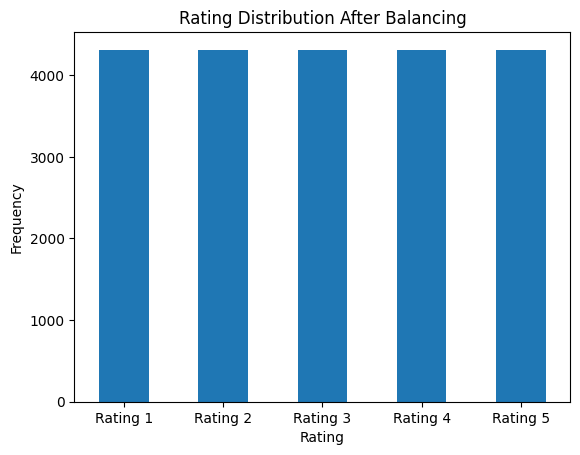

Rating 1: 20.00% Number of ratings: 4313
Rating 2: 20.00% Number of ratings: 4313
Rating 3: 20.00% Number of ratings: 4313
Rating 4: 20.00% Number of ratings: 4313
Rating 5: 20.00% Number of ratings: 4313


,number_reviews_scaled,review_time_encoded,text_word_length_scaled,Sentiment_VADER,Sentiment_Blob,bow_1920,local_hour
12058,2.247413,0,1.000560,-0.6604,0.075000,0,-1.058583
7303,-0.089733,0,-0.944640,0.0000,0.000000,0,1.755166
20704,-0.674019,0,-0.576629,-0.1531,0.000000,0,-0.455637
20528,2.247413,1,0.211965,0.3818,0.225000,0,-0.254655
5872,2.247413,1,-0.313764,-0.3612,0.416667,0,0.147309


(17252, 7)


In [119]:
#Anomaly detection

#Rejoin dataset
X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)
X_combined.reset_index(drop=True, inplace=True)
y_combined.reset_index(drop=True, inplace=True)
df_trustpilot = X_combined.copy()
df_trustpilot['rating'] = y_combined
df_trustpilot.reset_index(drop=True, inplace=True)
display(df_trustpilot.head())

#Display proportions
all = len(df_trustpilot)
one = df_trustpilot[df_trustpilot['rating'] == 1]
two = df_trustpilot[df_trustpilot['rating'] == 2]
three = df_trustpilot[df_trustpilot['rating'] == 3]
four = df_trustpilot[df_trustpilot['rating'] == 4]
five = df_trustpilot[df_trustpilot['rating'] == 5]
one_p = len(one)/all
two_p = len(two)/all
three_p = len(three)/all
four_p = len(four)/all
five_p = len(five)/all
print('One:',one_p*100,'%')
print("Number of one ratings:", len(one))
print('Two:',two_p*100,'%')
print("Number of two ratings:", len(two))
print('Three:',three_p*100,'%')
print("Number of three ratings:", len(three))
print('Four:',four_p*100,'%')
print("Number of four ratings:", len(four))
print('Five:',five_p*100,'%')
print("Number of five ratings:", len(five))

#Normalize the last feature
df_trustpilot['local_hour'] = StandardScaler().fit_transform(df_trustpilot['local_hour'].values.reshape(-1,1))
display(df_trustpilot.head())

#Rebalance the dataset
df_balanced = df_trustpilot.sample(frac=1, random_state=42)
rating_1 = df_balanced[df_balanced['rating'] == 1][:4313] 
rating_2 = df_balanced[df_balanced['rating'] == 2][:4313]      
rating_3 = df_balanced[df_balanced['rating'] == 3][:4313]  
rating_4 = df_balanced[df_balanced['rating'] == 4][:4313]  
rating_5 = df_balanced[df_balanced['rating'] == 5][:4313]  
df_balanced_final = pd.concat([rating_1, rating_2, rating_3, rating_4, rating_5])
df_balanced_final = df_balanced_final.sample(frac=1, random_state=42)
labels = ['Rating 1', 'Rating 2', 'Rating 3', 'Rating 4', 'Rating 5']
classes = pd.value_counts(df_balanced_final['rating'], sort=True)
classes.plot(kind='bar', rot=0)
plt.title("Rating Distribution After Balancing")
plt.xticks(range(5), labels)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()
for rating in range(1, 6):
    count = len(df_balanced_final[df_balanced_final['rating'] == rating])
    percentage = (count / len(df_balanced_final)) * 100
    print(f"Rating {rating}: {percentage:.2f}% Number of ratings: {count}")

X = df_balanced_final.drop('rating', axis=1)
y = df_balanced_final['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

display(X.head())
print(X_train.shape)

In [121]:
#Train base model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

#Evaluate base model
base_model_score = model.score(X_test, y_test)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
cm_2 = pd.crosstab(y_test, y_pred, rownames=['Reality'], colnames=['Prediction'])
y_probas = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probas, pos_label=1)
roc_auc = auc(fpr, tpr)

print("Accuracy: ", base_model_score * 100, "%")
print("ROC AUC: ", roc_auc * 100, "%")
print("Confusion matrix: ", "\n", cm)
print("PD Crosstab: ", "\n", cm_2)
print("Classification report: ", "\n", cr)

Accuracy:  42.615348945049845 %
ROC AUC:  64.82889071531731 %
Confusion matrix:  
 [[522 126 110  60  37]
 [241 195 218 123  58]
 [133 181 252 161 125]
 [ 67  89 171 255 312]
 [ 18  32  64 149 614]]
PD Crosstab:  
 Prediction    1    2    3    4    5
Reality                            
1           522  126  110   60   37
2           241  195  218  123   58
3           133  181  252  161  125
4            67   89  171  255  312
5            18   32   64  149  614
Classification report:  
               precision    recall  f1-score   support

           1       0.53      0.61      0.57       855
           2       0.31      0.23      0.27       835
           3       0.31      0.30      0.30       852
           4       0.34      0.29      0.31       894
           5       0.54      0.70      0.61       877

    accuracy                           0.43      4313
   macro avg       0.41      0.43      0.41      4313
weighted avg       0.41      0.43      0.41      4313



In [122]:
#Bagging
#Bagging Classifier
#Removed as accuracy dropped for our model
bc = BaggingClassifier(n_estimators=1000, oob_score=True)
bc.fit(X_train, y_train)

#Evaluate model with Bagging Classifier
y_pred_bc = bc.predict(X_test)
cm_bc = confusion_matrix(y_test, y_pred_bc)
cr_bc = classification_report(y_test, y_pred_bc)
cm_2_bc = pd.crosstab(y_test, y_pred_bc, rownames=['Reality'], colnames=['Prediction'])

print("OOB Score: ", bc.oob_score_)
print("Confusion matrix: ", "\n", cm_bc)
print("PD Crosstab: ", "\n", cm_2_bc)
print("Classification report: ", "\n", cr_bc)

OOB Score:  0.40140273591467657
Confusion matrix:  
 [[460 158 142  68  27]
 [223 207 227 114  64]
 [126 225 246 162  93]
 [ 79 148 176 241 250]
 [ 30  56  77 181 533]]
PD Crosstab:  
 Prediction    1    2    3    4    5
Reality                            
1           460  158  142   68   27
2           223  207  227  114   64
3           126  225  246  162   93
4            79  148  176  241  250
5            30   56   77  181  533
Classification report:  
               precision    recall  f1-score   support

           1       0.50      0.54      0.52       855
           2       0.26      0.25      0.25       835
           3       0.28      0.29      0.29       852
           4       0.31      0.27      0.29       894
           5       0.55      0.61      0.58       877

    accuracy                           0.39      4313
   macro avg       0.38      0.39      0.39      4313
weighted avg       0.38      0.39      0.39      4313



In [123]:
#Boosting
#Adaptive Boosting
#Removed as accuracy did not improve
ac = AdaBoostClassifier(estimator=model, n_estimators=2000)
ac.fit(X_train, y_train)

#Evaluate model with Adaptive Boosting
y_pred_ac = ac.predict(X_test)
cr_ac = classification_report(y_test, y_pred_ac)
cm_2_ac = pd.crosstab(y_test, y_pred_ac, rownames=['Reality'], colnames=['Prediction'])

print("PD Crosstab: ", "\n", cm_2_ac)
print("Classification report: ", "\n", cr_ac)


PD Crosstab:  
 Prediction    1    2    3    4    5
Reality                            
1           490  158  106   65   36
2           216  218  212  138   51
3           118  199  247  191   97
4            60  101  168  287  278
5            19   33   61  183  581
Classification report:  
               precision    recall  f1-score   support

           1       0.54      0.57      0.56       855
           2       0.31      0.26      0.28       835
           3       0.31      0.29      0.30       852
           4       0.33      0.32      0.33       894
           5       0.56      0.66      0.61       877

    accuracy                           0.42      4313
   macro avg       0.41      0.42      0.41      4313
weighted avg       0.41      0.42      0.42      4313



In [124]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
cm_2 = pd.crosstab(y_test, y_pred, rownames=['Reality'], colnames=['Prediction'])

print("Accuracy: ", base_model_score * 100, "%")
print("Confusion matrix: ", "\n", cm)
print("PD Crosstab: ", "\n", cm_2)
print("Classification report: ", "\n", cr)

Accuracy:  42.615348945049845 %
Confusion matrix:  
 [[495 138 136  54  32]
 [233 196 242 114  50]
 [117 162 304 178  91]
 [ 64  76 198 266 290]
 [ 17  27  65 168 600]]
PD Crosstab:  
 Prediction    1    2    3    4    5
Reality                            
1           495  138  136   54   32
2           233  196  242  114   50
3           117  162  304  178   91
4            64   76  198  266  290
5            17   27   65  168  600
Classification report:  
               precision    recall  f1-score   support

           1       0.53      0.58      0.56       855
           2       0.33      0.23      0.27       835
           3       0.32      0.36      0.34       852
           4       0.34      0.30      0.32       894
           5       0.56      0.68      0.62       877

    accuracy                           0.43      4313
   macro avg       0.42      0.43      0.42      4313
weighted avg       0.42      0.43      0.42      4313



In [125]:
# Current best model
# XGBoostClassifier with GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'scale_pos_weight': [1, 3, 5],
    'class_weight': ['balanced']
}
# Create and fit model with GridSearchCV
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob', 
    num_class=5,
    subsample=0.8,  # add these as fixed parameters instead
    colsample_bytree=0.8
)
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1_weighted',  # better for imbalanced data
    verbose=2  # increased verbosity to see progress
)

# Fit with 0-based labels
grid_search.fit(X_train, y_train - 1)

# Print best parameters
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Now use the best parameters with the original XGBoost implementation
best_params = grid_search.best_params_

# Adjust labels to be 0-based
y_train_0based = y_train - 1
y_test_0based = y_test - 1

# Create DMatrix objects with 0-based labels
train = xgb.DMatrix(X_train, y_train_0based)
test = xgb.DMatrix(X_test, y_test_0based)

# Set parameters using GridSearchCV results
params = {'booster': 'gbtree',
    'objective': 'multi:softprob',
    'num_class': 5,
    'learning_rate': best_params['learning_rate'],
    'max_depth': best_params['max_depth']}

# Train model
model = xgb.train(params,  dtrain=train, 
    num_boost_round=best_params['n_estimators'],
    early_stopping_rounds=15, 
    evals=[(train, 'train'), (test, 'eval')])

# Get predictions and convert back to 1-based
preds_prob = model.predict(test)
preds = np.argmax(preds_prob, axis=1) + 1  

# Print metrics
print("\nFinal Model Performance:")
print("Confusion Matrix - XGBoost: \n", confusion_matrix(y_test, preds))
print("\nClassification Report - XGBoost: \n", classification_report(y_test, preds))
print("\nROC AUC - XGBoost: ", roc_auc_score(
    pd.get_dummies(y_test), 
    preds_prob, 
    multi_class='ovr'))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END class_weight=balanced, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=1; total time=   0.7s
[CV] END class_weight=balanced, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=1; total time=   0.7s
[CV] END class_weight=balanced, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=1; total time=   0.7s
[CV] END class_weight=balanced, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=1; total time=   0.7s
[CV] END class_weight=balanced, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=1; total time=   0.7s
[CV] END class_weight=balanced, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=3; total time=   0.7s
[CV] END class_weight=balanced

In [97]:
#Ensemble method
#Voting Classifier
clf1 = KNeighborsClassifier(n_neighbors=3)
clf2 = RandomForestClassifier(random_state=123)
vclf = VotingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('lr', model)], voting='hard')
vclf.fit(X_train, y_train)
print("Voting Classifier Score:", vclf.score(X_test, y_test))

# Cross validation for each classifier
for clf, label in zip([clf1, clf2, model, vclf], 
                     ['KNN', 'Random Forest', 'Logistic Regression', 'Voting Classifier']):
    scores = cross_validate(clf, X_train, y_train, cv=5, scoring=['accuracy','f1_weighted'])
    print(f"\n[{label}]:")
    print(f"Accuracy: {scores['test_accuracy'].mean():.2f} (+/- {scores['test_accuracy'].std():.2f})")
    print(f"F1 score: {scores['test_f1_weighted'].mean():.2f} (+/- {scores['test_f1_weighted'].std():.2f})")

#Stacking Classifier
sclf = StackingClassifier(
    estimators=[('knn', clf1), ('rf', clf2), ('lr', model)],
    final_estimator=LogisticRegression(),
    cv=5
)

# Cross validation for Stacking
scores = cross_validate(sclf, X_train, y_train, cv=5, scoring=['accuracy', 'f1_weighted'])
print("\n[Stacking Classifier]:")
print(f"Accuracy: {scores['test_accuracy'].mean():.2f} (+/- {scores['test_accuracy'].std():.2f})")
print(f"F1 score: {scores['test_f1_weighted'].mean():.2f} (+/- {scores['test_f1_weighted'].std():.2f})")

# Final fit and score
sclf.fit(X_train, y_train)
print("Stacking Classifier Score:", sclf.score(X_test, y_test))

Voting Classifier Score: 0.6577060931899642

[KNN]:
Accuracy: 0.59 (+/- 0.00)
F1 score: 0.57 (+/- 0.00)

[Random Forest]:
Accuracy: 0.65 (+/- 0.00)
F1 score: 0.60 (+/- 0.00)

[Logistic Regression]:
Accuracy: 0.66 (+/- 0.00)
F1 score: 0.57 (+/- 0.00)

[Voting Classifier]:
Accuracy: 0.65 (+/- 0.00)
F1 score: 0.58 (+/- 0.00)

[Stacking Classifier]:
Accuracy: 0.66 (+/- 0.00)
F1 score: 0.59 (+/- 0.00)
Stacking Classifier Score: 0.6663549945457379


In [95]:
#Base model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

#Random Oversampling
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print(dict(pd.Series(y_ro).value_counts()))

model.fit(X_ro, y_ro)
y_pred = model.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

{2: np.int64(25088), 1: np.int64(25088), 5: np.int64(25088), 4: np.int64(25088), 3: np.int64(25088)}
col_0      1    2    3     4     5
rating                            
1       1986  419  418   263   102
2        247  195  232   130    59
3        217  240  390   250   157
4         86  115  224   371   461
5        137  168  420  1126  4421
                   pre       rec       spe        f1       geo       iba       sup

          1       0.74      0.62      0.93      0.68      0.76      0.56      3188
          2       0.17      0.23      0.92      0.20      0.46      0.19       863
          3       0.23      0.31      0.89      0.27      0.53      0.26      1254
          4       0.17      0.30      0.85      0.22      0.50      0.24      1257
          5       0.85      0.70      0.88      0.77      0.79      0.61      6272

avg / total       0.65      0.57      0.89      0.61      0.71      0.50     12834



In [98]:
from imblearn.combine import SMOTETomek
#Base model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

#SMOTE
smt = SMOTETomek()
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)
print(dict(pd.Series(y_resampled).value_counts()))

model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

{2: np.int64(23694), 1: np.int64(23405), 3: np.int64(23354), 4: np.int64(23017), 5: np.int64(22524)}
col_0      1    2    3     4     5
rating                            
1       1965  463  402   266    92
2        249  206  222   131    55
3        205  277  369   264   139
4         83  128  217   392   437
5        123  195  421  1227  4306
                   pre       rec       spe        f1       geo       iba       sup

          1       0.75      0.62      0.93      0.68      0.76      0.56      3188
          2       0.16      0.24      0.91      0.19      0.47      0.20       863
          3       0.23      0.29      0.89      0.26      0.51      0.25      1254
          4       0.17      0.31      0.84      0.22      0.51      0.25      1257
          5       0.86      0.69      0.89      0.76      0.78      0.60      6272

avg / total       0.65      0.56      0.90      0.60      0.70      0.49     12834



In [86]:
#Base model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

#SMOTE
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)
print(dict(pd.Series(y_sm).value_counts()))

model.fit(X_sm, y_sm)
y_pred = model.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

{2: np.int64(25088), 1: np.int64(25088), 5: np.int64(25088), 4: np.int64(25088), 3: np.int64(25088)}
col_0      1    2    3     4     5
rating                            
1       1998  436  395   252   107
2        256  205  221   123    58
3        219  259  368   252   156
4         88  121  219   378   451
5        144  174  429  1145  4380
                   pre       rec       spe        f1       geo       iba       sup

          1       0.74      0.63      0.93      0.68      0.76      0.56      3188
          2       0.17      0.24      0.92      0.20      0.47      0.20       863
          3       0.23      0.29      0.89      0.26      0.51      0.25      1254
          4       0.18      0.30      0.85      0.22      0.50      0.24      1257
          5       0.85      0.70      0.88      0.77      0.78      0.60      6272

avg / total       0.65      0.57      0.89      0.60      0.70      0.50     12834



In [87]:
#Base model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

#Random Undersampling
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)
print(dict(pd.Series(y_ru).value_counts()))

model.fit(X_ru, y_ru)
y_pred = model.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

{1: np.int64(3450), 2: np.int64(3450), 3: np.int64(3450), 4: np.int64(3450), 5: np.int64(3450)}
col_0      1    2    3     4     5
rating                            
1       1997  415  416   256   104
2        246  195  231   133    58
3        217  247  379   252   159
4         84  119  217   379   458
5        137  177  418  1121  4419
                   pre       rec       spe        f1       geo       iba       sup

          1       0.74      0.63      0.93      0.68      0.76      0.56      3188
          2       0.17      0.23      0.92      0.19      0.46      0.19       863
          3       0.23      0.30      0.89      0.26      0.52      0.25      1254
          4       0.18      0.30      0.85      0.22      0.51      0.24      1257
          5       0.85      0.70      0.88      0.77      0.79      0.61      6272

avg / total       0.65      0.57      0.89      0.61      0.71      0.50     12834



In [88]:
#Base model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

#ClusterCentroids
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X_train, y_train)
print(dict(pd.Series(y_cc).value_counts()))

model.fit(X_cc, y_cc)
y_pred = model.predict(X_test)
print(pd.crosstab(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

{1: np.int64(3450), 2: np.int64(3450), 3: np.int64(3450), 4: np.int64(3450), 5: np.int64(3450)}
col_0      1    2    3     4     5
rating                            
1       1741  760  259   238   190
2        216  286  138   139    84
3        165  370  248   279   192
4         66  160  139   404   488
5         98  222  242  1357  4353
                   pre       rec       spe        f1       geo       iba       sup

          1       0.76      0.55      0.94      0.64      0.72      0.49      3188
          2       0.16      0.33      0.87      0.21      0.54      0.27       863
          3       0.24      0.20      0.93      0.22      0.43      0.17      1254
          4       0.17      0.32      0.83      0.22      0.52      0.25      1257
          5       0.82      0.69      0.85      0.75      0.77      0.58      6272

avg / total       0.64      0.55      0.88      0.58      0.68      0.47     12834

